In [ ]:
!pip install tensorflow==2.12

In [ ]:
!wget https://s3.amazonaws.com/keras-datasets/jena_climate_2009_2016.csv.zip
!unzip jena_climate_2009_2016.csv.zip

--2024-11-02 14:22:33--  https://s3.amazonaws.com/keras-datasets/jena_climate_2009_2016.csv.zip
Resolving s3.amazonaws.com (s3.amazonaws.com)... 54.231.165.80, 52.217.116.120, 16.15.192.53, ...
Connecting to s3.amazonaws.com (s3.amazonaws.com)|54.231.165.80|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 13565642 (13M) [application/zip]
Saving to: ‘jena_climate_2009_2016.csv.zip’

jena_climate_2009_2 100%[===================>]  12.94M  20.8MB/s    in 0.6s    

2024-11-02 14:22:34 (20.8 MB/s) - ‘jena_climate_2009_2016.csv.zip’ saved [13565642/13565642]

Archive:  jena_climate_2009_2016.csv.zip
  inflating: jena_climate_2009_2016.csv  
  inflating: __MACOSX/._jena_climate_2009_2016.csv  


Analysis of the data of the Jena weather dataset - 420451 rows and 15 Features

In [ ]:
import os
fname = os.path.join("jena_climate_2009_2016.csv")

with open(fname) as f:
    data = f.read()

line1 = data.split("\n")
header1 = line1[0].split(",")
line1 = line1[1:]
print(header1)
print(len(line1))

num_variables = len(header1)
print("Number of variables:", num_variables)
num_rows = len(line1)
print("Number of rows:", num_rows)

['"Date Time"', '"p (mbar)"', '"T (degC)"', '"Tpot (K)"', '"Tdew (degC)"', '"rh (%)"', '"VPmax (mbar)"', '"VPact (mbar)"', '"VPdef (mbar)"', '"sh (g/kg)"', '"H2OC (mmol/mol)"', '"rho (g/m**3)"', '"wv (m/s)"', '"max. wv (m/s)"', '"wd (deg)"']
420451
Number of variables: 15
Number of rows: 420451


Following data analysis, specific values are kept in the temperature and raw_data arrays for subsequent processing or analysis. Comma-separated values are transformed to floating-point numbers.

In [ ]:
import numpy as np
temp1 = np.zeros((len(line1),))
rawdata1 = np.zeros((len(line1), len(header1) - 1))
for i, line in enumerate(line1):
    values = [float(x) for x in line.split(",")[1:]]
    temp1[i] = values[1]
    rawdata1[i, :] = values[:]

The temperature timeseries plot

Text(0, 0.5, 'Temperature')

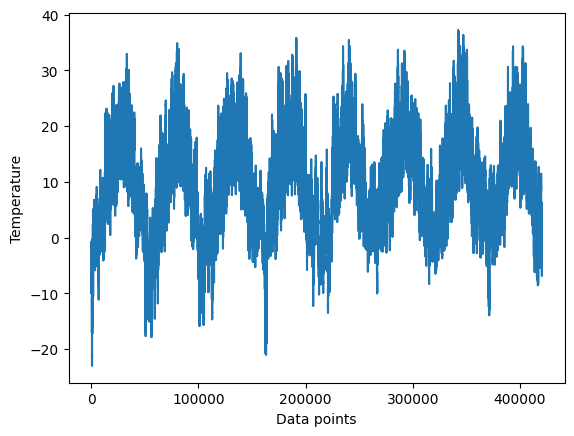

In [ ]:
from matplotlib import pyplot as plt
plt.plot(range(len(temp1)), temp1)
plt.xlabel('Data points')
plt.ylabel('Temperature')

The temperature time series for the initial 10 days is plotted. 144 data points are gathered in a single day, therefore 1440 data points will be acquired in ten days.

Text(0, 0.5, 'Temperature')

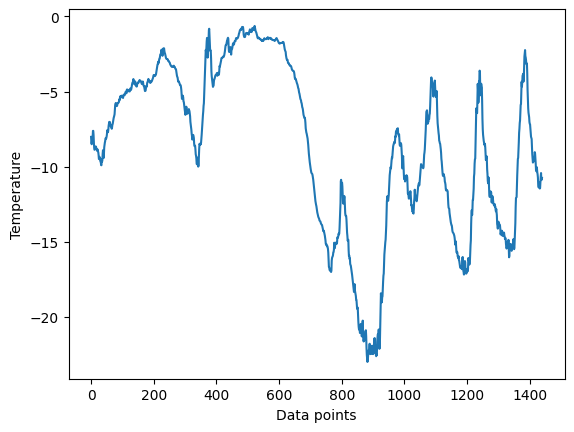

In [ ]:
plt.plot(range(1440), temp1[:1440])
plt.xlabel('Data points')
plt.ylabel('Temperature')

Figuring out how many samples we'll need for each data split (train = 50%, validation = 25%).

In [ ]:
train_data = int(0.5 * len(rawdata1))
validation_data= int(0.25 * len(rawdata1))
test_data= len(rawdata1) - train_data - validation_data
print("Number of train samples:", train_data)
print("Number of validation samples:", validation_data)
print("Number of test samples:", test_data)

Number of train samples: 210225
Number of validation samples: 105112
Number of test samples: 105114


Preparing the data


Normalizing the data: Since the data is already represented numerically, vectorization is not necessary. Nevertheless, because the data scales differ among them—temperature goes from -20 to +30, and pressure is measured in millibars—it is advisable to standardize all variables.

In [ ]:
mean1 = rawdata1[:train_data].mean(axis=0)
rawdata1 -= mean1
std = rawdata1[:train_data].std(axis=0)
rawdata1 /= std

In [ ]:
import numpy as np
from tensorflow import keras
int_sequence1 = np.arange(10)
dummy_dataset_1 = keras.utils.timeseries_dataset_from_array(
    data=int_sequence1[:-3],
    targets=int_sequence1[3:],
    sequence_length=3,
    batch_size=2,
)

for inputs, targets in dummy_dataset_1:
    for i in range(inputs.shape[0]):
        print([int(x) for x in inputs[i]], int(targets[i]))

[0, 1, 2] 3
[1, 2, 3] 4
[2, 3, 4] 5
[3, 4, 5] 6
[4, 5, 6] 7


A significant amount of duplication in the dataset's sample makes the creation of training, validation, and testing datasets essential. To actively allocate RAM for each sample would therefore be inefficient. Instead, the samples will be generated in real time.

In [ ]:
sample_rate = 6
sequencelength = 120
delay = sample_rate * (sequencelength + 24 - 1)
batch_size = 256

training_data = keras.utils.timeseries_dataset_from_array(
    rawdata1[:-delay],
    targets=temp1[delay:],
    sampling_rate=sample_rate,
    sequence_length=sequencelength,
    shuffle=True,
    batch_size=batch_size,
    start_index=0,
    end_index=train_data)

validation_data = keras.utils.timeseries_dataset_from_array(
    rawdata1[:-delay],
    targets=temp1[delay:],
    sampling_rate=sample_rate,
    sequence_length=sequencelength,
    shuffle=True,
    batch_size=batch_size,
    start_index=train_data,
    end_index=train_data + validation_data)

testing_data = keras.utils.timeseries_dataset_from_array(
    rawdata1[:-delay],
    targets=temp1[delay:],
    sampling_rate=sample_rate,
    sequence_length=sequencelength,
    shuffle=True,
    batch_size=batch_size,
    start_index=train_data + validation_data)

Generating the output of one of this datasets

In [ ]:
for samples, targets in training_data:
    print("samples shape:", samples.shape)
    print("targets shape:", targets.shape)
    break

samples shape: (256, 120, 14)
targets shape: (256,)


A common-sense, non-machine-learning baseline


Calculating the common-sense baseline MAE: The specified function "evaluate_naive_method" provides a foundation for evaluating the efficacy of a simple forecasting method that predicts the value that follows a given value using the final value in the input sequence.

In [ ]:
def evaluate_naive_method(dataset):
    total_absolute_error = 0.
    samples_saw = 0
    for samples, targets in dataset:
        preds = samples[:, -1, 1] * std[1] + mean1[1]
        total_absolute_error += np.sum(np.abs(preds - targets))
        samples_saw += samples.shape[0]
    return total_absolute_error / samples_saw

print(f"Validation MAE: {evaluate_naive_method(validation_data):.2f}")
print(f"Test MAE: {evaluate_naive_method(testing_data):.2f}")

Validation MAE: 2.44
Test MAE: 2.62


Predicting that the temperature will be the same 24 hours from now is a Common sense basilne approach. The validation mean absolute error (MAE) is 2.44 degrees Celsius whereas the test mean is 2.62 degrees Celsius utilizing this simple baseline. Stated otherwise, there would be an average variance of around 2.5 degrees if the future temperature were constant with the present one.

A basic machine-learning model - Dense Layer


Training and evaluating a densely connected model

In [ ]:
from tensorflow import keras
from tensorflow.keras import layers

inputs = keras.Input(shape=(sequencelength, rawdata1.shape[-1]))
G1 = layers.Flatten()(inputs)
G1 = layers.Dense(16, activation="relu")(G1)
outputs = layers.Dense(1)(G1)
model = keras.Model(inputs, outputs)

In [ ]:
callbacks = [
    keras.callbacks.ModelCheckpoint("jena_dense.keras",
                                    save_best_only=True)]

model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])


history = model.fit(training_data, epochs=20,
                    validation_data = validation_data, callbacks=callbacks)

Epoch 1/20
819/819 [==============================] - 49s 60ms/step - loss: 7.2481 - mae: 2.1194 - val_loss: 11.0623 - val_mae: 2.6401
Epoch 2/20
819/819 [==============================] - 40s 49ms/step - loss: 7.0278 - mae: 2.0882 - val_loss: 11.3475 - val_mae: 2.6789
Epoch 3/20
819/819 [==============================] - 39s 47ms/step - loss: 6.8874 - mae: 2.0669 - val_loss: 10.8806 - val_mae: 2.6188
Epoch 4/20
819/819 [==============================] - 39s 48ms/step - loss: 6.7653 - mae: 2.0492 - val_loss: 12.7816 - val_mae: 2.8354
Epoch 5/20
819/819 [==============================] - 39s 47ms/step - loss: 6.6433 - mae: 2.0305 - val_loss: 13.7029 - val_mae: 2.9342
Epoch 6/20
819/819 [==============================] - 48s 58ms/step - loss: 6.5739 - mae: 2.0206 - val_loss: 11.0939 - val_mae: 2.6453
Epoch 7/20
819/819 [==============================] - 39s 47ms/step - loss: 6.4814 - mae: 2.0068 - val_loss: 11.5725 - val_mae: 2.6984
Epoch 8/20
819/819 [==============================] - 3

In [ ]:
model = keras.models.load_model("jena_dense.keras")
print(f"Test MAE: {model.evaluate(testing_data)[1]:.2f}")

405/405 [==============================] - 15s 35ms/step - loss: 11.7282 - mae: 2.6815
Test MAE: 2.68


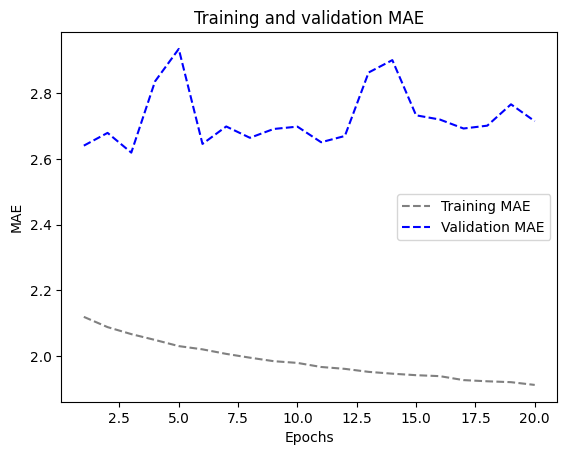

In [ ]:
import matplotlib.pyplot as plt
loss1 = history.history["mae"]
validation_loss = history.history["val_mae"]

epochs = range(1, len(loss1) + 1)
plt.figure()
plt.plot(epochs, loss1, color="grey", linestyle="dashed", label="Training MAE")
plt.plot(epochs,  validation_loss, color="blue",linestyle="dashed", label="Validation MAE")
plt.title("Training and validation MAE")
plt.xlabel("Epochs")
plt.ylabel("MAE")
plt.legend()
plt.show()

Let's try a 1D convolutional model

In [ ]:
inputs = keras.Input(shape=(sequencelength, rawdata1.shape[-1]))
x = layers.Conv1D(8, 24, activation="relu")(inputs)
x = layers.MaxPooling1D(2)(x)
x = layers.Conv1D(8, 12, activation="relu")(x)
x = layers.MaxPooling1D(2)(x)
x = layers.Conv1D(8, 6, activation="relu")(x)
x = layers.GlobalAveragePooling1D()(x)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

In [ ]:

callbacks = [
    keras.callbacks.ModelCheckpoint("jena_conv.keras",
                                    save_best_only=True)
]
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history1D = model.fit(training_data,
                    epochs=10,
                    validation_data=validation_data,
                    callbacks=callbacks)

model_to_dot = keras.models.load_model("jena_conv.keras")
print(f"Test MAE: {model.evaluate(testing_data)[1]:.2f}")

Epoch 1/10
819/819 [==============================] - 75s 91ms/step - loss: 28.4021 - mae: 4.1228 - val_loss: 18.6391 - val_mae: 3.4062
Epoch 2/10
819/819 [==============================] - 71s 86ms/step - loss: 17.4012 - mae: 3.3065 - val_loss: 16.2496 - val_mae: 3.1784
Epoch 3/10
819/819 [==============================] - 72s 88ms/step - loss: 14.8686 - mae: 3.0564 - val_loss: 18.6453 - val_mae: 3.4126
Epoch 4/10
819/819 [==============================] - 71s 87ms/step - loss: 13.9099 - mae: 2.9523 - val_loss: 15.6789 - val_mae: 3.1024
Epoch 5/10
819/819 [==============================] - 77s 93ms/step - loss: 13.1418 - mae: 2.8699 - val_loss: 16.8981 - val_mae: 3.2363
Epoch 6/10
819/819 [==============================] - 78s 95ms/step - loss: 12.5372 - mae: 2.8041 - val_loss: 18.8437 - val_mae: 3.4184
Epoch 7/10
819/819 [==============================] - 76s 93ms/step - loss: 12.0677 - mae: 2.7469 - val_loss: 15.4756 - val_mae: 3.0793
Epoch 8/10
819/819 [============================

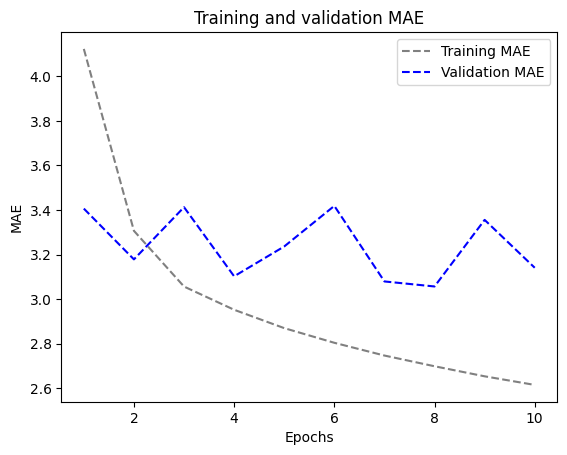

In [ ]:
import matplotlib.pyplot as plt
loss_1D = history1D.history["mae"]
validation_loss_1D = history1D.history["val_mae"]

epochs = range(1, len(loss_1D) + 1)
plt.figure()
plt.plot(epochs, loss_1D, color="grey", linestyle="dashed", label="Training MAE")
plt.plot(epochs,  validation_loss_1D, color="blue",linestyle="dashed", label="Validation MAE")
plt.title("Training and validation MAE")
plt.xlabel("Epochs")
plt.ylabel("MAE")
plt.legend()
plt.show()

Dense models or common sense seem to outperform convolutional data. That might be because of

Weather data does not conform to the translation invariance assumption.
The order in which the information is provided is crucial. Recent past data is notably more beneficial than data acquired many days in advance when it comes to predicting the temperature for the next day. Sadly, a 1D convolutional neural network is not able to adequately represent this significant temporal order.

A Simple RNN

1.An RNN layer that can process sequences of any length

In [ ]:
the_features = 14
input_RNN = keras.Input(shape=(None, the_features))
output_RNN = layers.SimpleRNN(16)(input_RNN)

model_RNN = keras.Model(input_RNN, output_RNN)

callbacks = [
    keras.callbacks.ModelCheckpoint("jena_SimRNN.keras",
                                    save_best_only=True)
]
model_RNN.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history_RNN = model_RNN.fit(training_data,
                    epochs=5,
                    validation_data=validation_data,
                    callbacks=callbacks)

model_RNN = keras.models.load_model("jena_SimRNN.keras")
print(f"Test MAE: {model_RNN.evaluate(testing_data)[1]:.2f}")

Epoch 1/5
819/819 [==============================] - 58s 70ms/step - loss: 138.4120 - mae: 9.6802 - val_loss: 143.8775 - val_mae: 9.8821
Epoch 2/5
819/819 [==============================] - 60s 73ms/step - loss: 136.3803 - mae: 9.5556 - val_loss: 143.7549 - val_mae: 9.8711
Epoch 3/5
819/819 [==============================] - 57s 69ms/step - loss: 136.2980 - mae: 9.5482 - val_loss: 143.6700 - val_mae: 9.8622
Epoch 4/5
819/819 [==============================] - 57s 69ms/step - loss: 136.2540 - mae: 9.5460 - val_loss: 143.6132 - val_mae: 9.8555
Epoch 5/5
405/405 [==============================] - 16s 39ms/step - loss: 151.3712 - mae: 9.9253
Test MAE: 9.93


2.Simple RNN - Stacking RNN layers

In [ ]:
the_features2 = 14
steps = 120
input_2 = keras.Input(shape=(steps, the_features2))
a = layers.SimpleRNN(16, return_sequences=True)(input_2)
a = layers.SimpleRNN(16, return_sequences=True)(a)
output_2 = layers.SimpleRNN(16)(a)
models2 = keras.Model(input_2, output_2)

callbacks = [
    keras.callbacks.ModelCheckpoint("jena_SRNN2.keras",
                                    save_best_only=True)
]
models2.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history2 = models2.fit(training_data,
                    epochs=5,
                    validation_data=validation_data,
                    callbacks=callbacks)

models2 = keras.models.load_model("jena_SRNN2.keras")
print(f"Test MAE: {models2.evaluate(testing_data)[1]:.2f}")

Epoch 1/5
819/819 [==============================] - 105s 125ms/step - loss: 137.1156 - mae: 9.5797 - val_loss: 143.4611 - val_mae: 9.8416
Epoch 2/5
819/819 [==============================] - 102s 125ms/step - loss: 135.9788 - mae: 9.5166 - val_loss: 143.4401 - val_mae: 9.8377
Epoch 3/5
819/819 [==============================] - 104s 127ms/step - loss: 135.9302 - mae: 9.5101 - val_loss: 143.4116 - val_mae: 9.8351
Epoch 4/5
819/819 [==============================] - 103s 126ms/step - loss: 135.9012 - mae: 9.5069 - val_loss: 143.4165 - val_mae: 9.8339
Epoch 5/5
405/405 [==============================] - 22s 51ms/step - loss: 151.1482 - mae: 9.9032
Test MAE: 9.90


A Simple GRU (Gated Recurrent Unit)

In [ ]:
inputs_GRU = keras.Input(shape=(sequencelength, rawdata1.shape[-1]))
b = layers.GRU(16)(inputs_GRU)
outputs_GRU = layers.Dense(1)(b)
models_GRU = keras.Model(inputs_GRU, outputs_GRU)

callbacks = [
    keras.callbacks.ModelCheckpoint("jena_gru.keras",
                                    save_best_only=True)
]
models_GRU.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history_GRU = models_GRU.fit(training_data,
                    epochs=5,
                    validation_data=validation_data,
                    callbacks=callbacks)

models_GRU = keras.models.load_model("jena_gru.keras")
print(f"Test MAE: {models_GRU.evaluate(testing_data)[1]:.2f}")

Epoch 1/5
819/819 [==============================] - 90s 107ms/step - loss: 47.4593 - mae: 5.0396 - val_loss: 14.3720 - val_mae: 2.8265
Epoch 2/5
819/819 [==============================] - 88s 107ms/step - loss: 10.8538 - mae: 2.5552 - val_loss: 10.0088 - val_mae: 2.4314
Epoch 3/5
819/819 [==============================] - 88s 107ms/step - loss: 9.5460 - mae: 2.4139 - val_loss: 9.8747 - val_mae: 2.4139
Epoch 4/5
819/819 [==============================] - 86s 105ms/step - loss: 9.2097 - mae: 2.3687 - val_loss: 9.8311 - val_mae: 2.4122
Epoch 5/5
405/405 [==============================] - 20s 48ms/step - loss: 9.7430 - mae: 2.4585
Test MAE: 2.46


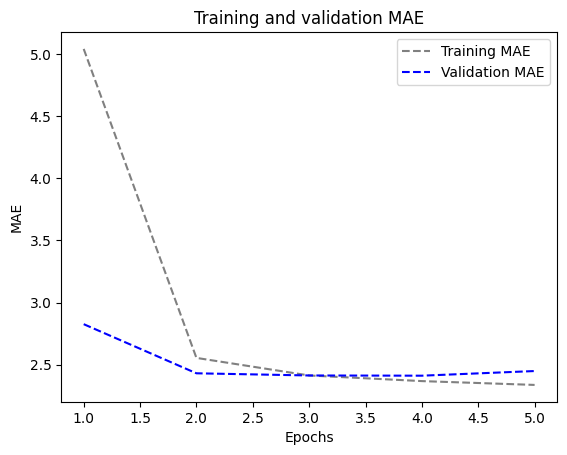

In [ ]:
import matplotlib.pyplot as plt
loss_GRU = history_GRU.history["mae"]
validation_loss_GRU = history_GRU.history["val_mae"]

epochs = range(1, len(loss_GRU) + 1)
plt.figure()
plt.plot(epochs, loss_GRU, color="grey", linestyle="dashed", label="Training MAE")
plt.plot(epochs,  validation_loss_GRU, color="blue",linestyle="dashed", label="Validation MAE")
plt.title("Training and validation MAE")
plt.xlabel("Epochs")
plt.ylabel("MAE")
plt.legend()
plt.show()

LSTM(Long Short-Term Memory )

1.LSTM-Simple

In [ ]:
inputs_LSTMS = keras.Input(shape=(sequencelength, rawdata1.shape[-1]))
c = layers.LSTM(16)(inputs_LSTMS)
output_LSTMS = layers.Dense(1)(c)
model_LSTMS = keras.Model(inputs_LSTMS, output_LSTMS)

callbacks = [
    keras.callbacks.ModelCheckpoint("jena_lstm.keras",
                                    save_best_only=True)
]
model_LSTMS.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history_LSTMS = model_LSTMS.fit(training_data,
                    epochs=5,
                    validation_data=validation_data,
                    callbacks=callbacks)



Epoch 1/5
819/819 [==============================] - 88s 105ms/step - loss: 47.6223 - mae: 5.0562 - val_loss: 13.6726 - val_mae: 2.7914
Epoch 2/5
819/819 [==============================] - 89s 108ms/step - loss: 11.2046 - mae: 2.5906 - val_loss: 9.6486 - val_mae: 2.4170
Epoch 3/5
819/819 [==============================] - 88s 107ms/step - loss: 9.6920 - mae: 2.4268 - val_loss: 9.7718 - val_mae: 2.4199
Epoch 4/5
819/819 [==============================] - 88s 107ms/step - loss: 9.2506 - mae: 2.3702 - val_loss: 10.2759 - val_mae: 2.4509
Epoch 5/5
819/819 [==============================] - 88s 108ms/step - loss: 8.9367 - mae: 2.3342 - val_loss: 9.9628 - val_mae: 2.4198


In [ ]:
model_LSTMS = keras.models.load_model("jena_lstm.keras")
print(f"Test MAE: {model_LSTMS.evaluate(testing_data)[1]:.2f}")

405/405 [==============================] - 21s 51ms/step - loss: 12.8581 - mae: 2.7009
Test MAE: 2.70


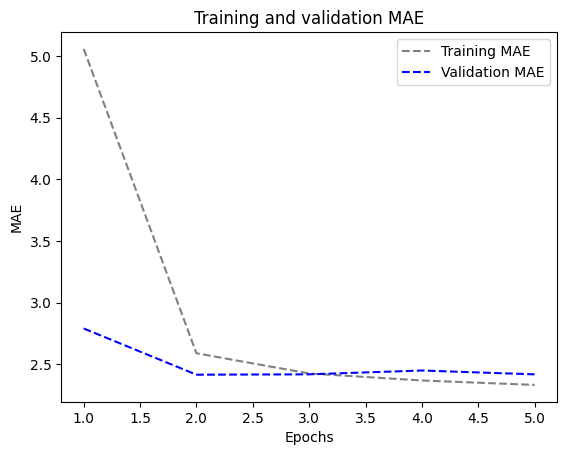

In [ ]:
import matplotlib.pyplot as plt
loss_LSTMS = history_LSTMS.history["mae"]
validation_loss_LSTMS = history_LSTMS.history["val_mae"]

epochs = range(1, len(loss_LSTMS) + 1)
plt.figure()
plt.plot(epochs, loss_LSTMS, color="grey", linestyle="dashed", label="Training MAE")
plt.plot(epochs,  validation_loss_LSTMS, color="blue",linestyle="dashed", label="Validation MAE")
plt.title("Training and validation MAE")
plt.xlabel("Epochs")
plt.ylabel("MAE")
plt.legend()
plt.show()

2.LSTM - dropout Regularization

In [ ]:
input_LSTMR = keras.Input(shape=(sequencelength, rawdata1.shape[-1]))
d = layers.LSTM(16, recurrent_dropout=0.25)(input_LSTMR )
d = layers.Dropout(0.5)(d)
output_LSTMR = layers.Dense(1)(d)
model_LSTMR = keras.Model(input_LSTMR , output_LSTMR )

callbacks = [
    keras.callbacks.ModelCheckpoint("jena_lstm_dropout.keras",
                                    save_best_only=True)
]
model_LSTMR.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history_LSTMR = model_LSTMR.fit(training_data,
                    epochs=5,
                    validation_data=validation_data,
                    callbacks=callbacks)



Epoch 1/5
819/819 [==============================] - 142s 170ms/step - loss: 50.9910 - mae: 5.3147 - val_loss: 13.7376 - val_mae: 2.7994
Epoch 2/5
819/819 [==============================] - 139s 169ms/step - loss: 20.1106 - mae: 3.4431 - val_loss: 10.1146 - val_mae: 2.4761
Epoch 3/5
819/819 [==============================] - 141s 171ms/step - loss: 18.2539 - mae: 3.2900 - val_loss: 9.5590 - val_mae: 2.4139
Epoch 4/5
819/819 [==============================] - 141s 172ms/step - loss: 17.3563 - mae: 3.2070 - val_loss: 9.4089 - val_mae: 2.3921
Epoch 5/5
819/819 [==============================] - 140s 171ms/step - loss: 16.7125 - mae: 3.1426 - val_loss: 9.4269 - val_mae: 2.3973


In [ ]:
model_LSTMR = keras.models.load_model("jena_lstm_dropout.keras")
print(f"Test MAE: {model_LSTMR.evaluate(testing_data)[1]:.2f}")

405/405 [==============================] - 23s 55ms/step - loss: 11.0264 - mae: 2.6063
Test MAE: 2.61


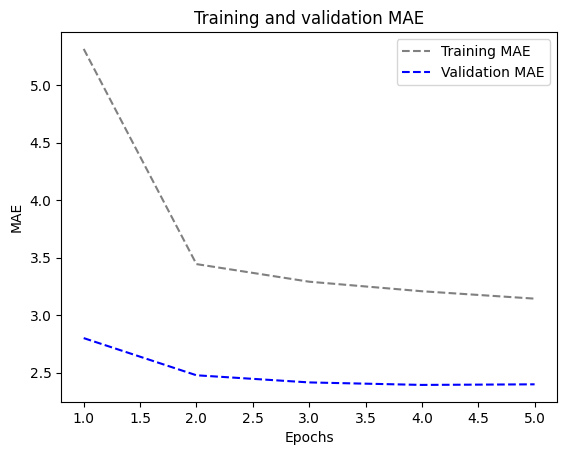

In [ ]:
import matplotlib.pyplot as plt
loss_LSTMR = history_LSTMR .history["mae"]
validation_loss_LSTMR = history_LSTMR .history["val_mae"]

epochs = range(1, len(loss_LSTMR) + 1)
plt.figure()
plt.plot(epochs, loss_LSTMR, color="grey", linestyle="dashed", label="Training MAE")
plt.plot(epochs,  validation_loss_LSTMR, color="blue",linestyle="dashed", label="Validation MAE")
plt.title("Training and validation MAE")
plt.xlabel("Epochs")
plt.ylabel("MAE")
plt.legend()
plt.show()

3.LSTM - Stacked setup with 16 units

In [ ]:
input_LSTM16 = keras.Input(shape=(sequencelength, rawdata1.shape[-1]))
e = layers.LSTM(16, return_sequences=True)(input_LSTM16)
e = layers.LSTM(16)(e)
output_LSTM16 = layers.Dense(1)(e)
model_LSTM16 = keras.Model(input_LSTM16, output_LSTM16)

callbacks = [
    keras.callbacks.ModelCheckpoint("jena_LSTM_stacked1.keras",
                                    save_best_only=True)
]
model_LSTM16.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history_16 = model_LSTM16.fit(training_data,
                    epochs=5,
                    validation_data=validation_data,
                    callbacks=callbacks)


Epoch 1/5
819/819 [==============================] - 149s 178ms/step - loss: 39.4415 - mae: 4.5398 - val_loss: 12.9280 - val_mae: 2.7208
Epoch 2/5
819/819 [==============================] - 144s 176ms/step - loss: 10.2395 - mae: 2.4846 - val_loss: 10.1512 - val_mae: 2.4865
Epoch 3/5
819/819 [==============================] - 143s 175ms/step - loss: 8.9428 - mae: 2.3285 - val_loss: 11.3168 - val_mae: 2.6414
Epoch 4/5
819/819 [==============================] - 144s 176ms/step - loss: 8.2842 - mae: 2.2408 - val_loss: 10.8747 - val_mae: 2.5851
Epoch 5/5
819/819 [==============================] - 146s 178ms/step - loss: 7.7851 - mae: 2.1695 - val_loss: 10.7338 - val_mae: 2.5595


In [ ]:
model_LSTM16 = keras.models.load_model("jena_LSTM_stacked1.keras")
print(f"Test MAE: {model_LSTM16.evaluate(testing_data)[1]:.2f}")

405/405 [==============================] - 29s 70ms/step - loss: 11.5192 - mae: 2.6486
Test MAE: 2.65


In [ ]:
import matplotlib.pyplot as plt
loss_LSTM16 = history_16.history["mae"]
validation_loss_LSTM16 = history_16.history["val_mae"]

epochs = range(1, len(loss_LSTM16) + 1)
plt.figure()
plt.plot(epochs, loss_LSTM16, color="grey", linestyle="dashed", label="Training MAE")
plt.plot(epochs,  validation_loss_LSTM16, color="blue",linestyle="dashed", label="Validation MAE")
plt.title("Training and validation MAE")
plt.xlabel("Epochs")
plt.ylabel("MAE")
plt.legend()
plt.show()

NameError: name 'history_16' is not defined

4.LSTM - Stacked setup with 32 units

In [ ]:
input_LSTM32 = keras.Input(shape=(sequencelength, rawdata1.shape[-1]))
f = layers.LSTM(32, return_sequences=True)(input_LSTM32)
f = layers.LSTM(32)(f)
output_LSTM32 = layers.Dense(1)(f)
model_LSTM32 = keras.Model(input_LSTM32, output_LSTM32)

callbacks = [
    keras.callbacks.ModelCheckpoint("jena_LSTM_stacked2.keras",
                                    save_best_only=True)
]
model_LSTM32.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history_32 = model_LSTM32.fit(training_data,
                    epochs=10,
                    validation_data=validation_data,
                    callbacks=callbacks)


NameError: name 'keras' is not defined

In [ ]:
model_LSTM32 = keras.models.load_model("jena_LSTM_stacked2.keras")
print(f"Test MAE: {model_LSTM32.evaluate(testing_data)[1]:.2f}")

405/405 [==============================] - 27s 64ms/step - loss: 11.7041 - mae: 2.6838
Test MAE: 2.68


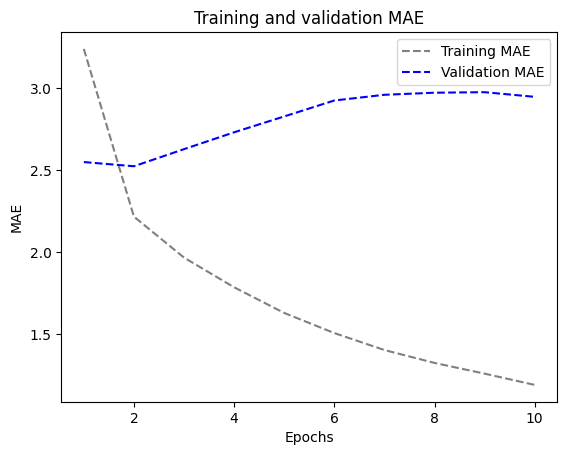

In [ ]:
import matplotlib.pyplot as plt
loss_LSTM32 = history_32.history["mae"]
validation_loss_LSTM32 = history_32.history["val_mae"]

epochs = range(1, len(loss_LSTM32) + 1)
plt.figure()
plt.plot(epochs, loss_LSTM32, color="grey", linestyle="dashed", label="Training MAE")
plt.plot(epochs,  validation_loss_LSTM32, color="blue",linestyle="dashed", label="Validation MAE")
plt.title("Training and validation MAE")
plt.xlabel("Epochs")
plt.ylabel("MAE")
plt.legend()
plt.show()

5.LSTM - Stacked setup with 8 units

In [ ]:
input_8u = keras.Input(shape=(sequencelength, rawdata1.shape[-1]))
h = layers.LSTM(8, return_sequences=True)(input_8u)
h = layers.LSTM(8)(h)
output_8u = layers.Dense(1)(h)
model_8u = keras.Model(input_8u, output_8u)

callbacks = [
    keras.callbacks.ModelCheckpoint("jena_LSTM_stacked3.keras",
                                    save_best_only=True)
]
model_8u.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history_8u = model_8u.fit(training_data,
                    epochs=10,
                    validation_data=validation_data,
                    callbacks=callbacks)


Epoch 1/10
819/819 [==============================] - 85s 100ms/step - loss: 70.6401 - mae: 6.4259 - val_loss: 35.1753 - val_mae: 4.3867
Epoch 2/10
819/819 [==============================] - 81s 99ms/step - loss: 21.0936 - mae: 3.3918 - val_loss: 12.8402 - val_mae: 2.6921
Epoch 3/10
819/819 [==============================] - 82s 99ms/step - loss: 11.1445 - mae: 2.5822 - val_loss: 10.0331 - val_mae: 2.4593
Epoch 4/10
819/819 [==============================] - 81s 99ms/step - loss: 9.9313 - mae: 2.4547 - val_loss: 9.9301 - val_mae: 2.4462
Epoch 5/10
819/819 [==============================] - 81s 99ms/step - loss: 9.6237 - mae: 2.4147 - val_loss: 10.0378 - val_mae: 2.4652
Epoch 6/10
819/819 [==============================] - 82s 99ms/step - loss: 9.4078 - mae: 2.3863 - val_loss: 9.8334 - val_mae: 2.4448
Epoch 7/10
819/819 [==============================] - 81s 99ms/step - loss: 9.1820 - mae: 2.3537 - val_loss: 9.8662 - val_mae: 2.4506
Epoch 8/10
819/819 [==============================] - 

In [ ]:
model_8u = keras.models.load_model("jena_LSTM_stacked3.keras")
print(f"Test MAE: {model_8u.evaluate(testing_data)[1]:.2f}")

405/405 [==============================] - 14s 33ms/step - loss: 10.7092 - mae: 2.5793
Test MAE: 2.58


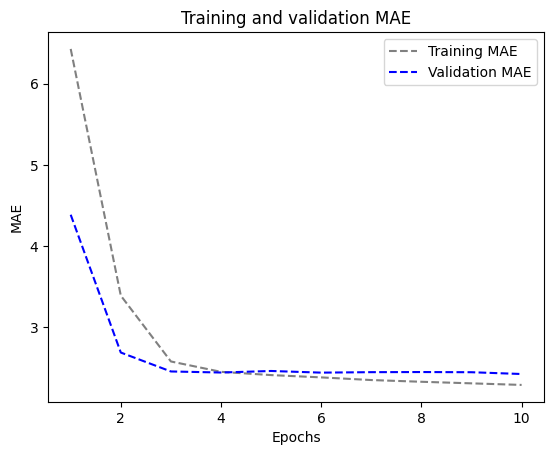

In [ ]:
import matplotlib.pyplot as plt
loss_8u = history_8u.history["mae"]
validation_loss_8u = history_8u.history["val_mae"]

epochs = range(1, len(loss_8u) + 1)
plt.figure()
plt.plot(epochs, loss_8u, color="grey", linestyle="dashed", label="Training MAE")
plt.plot(epochs,  validation_loss_8u, color="blue",linestyle="dashed", label="Validation MAE")
plt.title("Training and validation MAE")
plt.xlabel("Epochs")
plt.ylabel("MAE")
plt.legend()
plt.show()

6.LSTM - dropout-regularized, stacked model

In [ ]:
inputs = keras.Input(shape=(sequencelength, rawdata1.shape[-1]))
i = layers.LSTM(8, recurrent_dropout=0.5, return_sequences=True)(inputs)
i = layers.LSTM(8, recurrent_dropout=0.5)(i)
i = layers.Dropout(0.5)(i)
outputs = layers.Dense(1)(i)
model = keras.Model(inputs, outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint("jena_stacked_LSTM_dropout.keras",
                                    save_best_only=True)
]
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(training_data,
                    epochs=10,
                    validation_data=validation_data,
                    callbacks=callbacks)


Epoch 1/10
819/819 [==============================] - 123s 146ms/step - loss: 74.0595 - mae: 6.6088 - val_loss: 34.7545 - val_mae: 4.3899
Epoch 2/10
819/819 [==============================] - 119s 146ms/step - loss: 31.8577 - mae: 4.2218 - val_loss: 13.6903 - val_mae: 2.7574
Epoch 3/10
819/819 [==============================] - 119s 145ms/step - loss: 24.4364 - mae: 3.7448 - val_loss: 11.2331 - val_mae: 2.5636
Epoch 4/10
819/819 [==============================] - 119s 146ms/step - loss: 22.4799 - mae: 3.5999 - val_loss: 10.0102 - val_mae: 2.4320
Epoch 5/10
819/819 [==============================] - 119s 145ms/step - loss: 21.2827 - mae: 3.5031 - val_loss: 9.5838 - val_mae: 2.3791
Epoch 6/10
819/819 [==============================] - 119s 145ms/step - loss: 20.2977 - mae: 3.4310 - val_loss: 9.5677 - val_mae: 2.3815
Epoch 7/10
819/819 [==============================] - 119s 145ms/step - loss: 19.3459 - mae: 3.3558 - val_loss: 9.5638 - val_mae: 2.3905
Epoch 8/10
819/819 [=================

In [ ]:
model_r = keras.models.load_model("jena_stacked_LSTM_dropout.keras")
print(f"Test MAE: {model_r.evaluate(testing_data)[1]:.2f}")

405/405 [==============================] - 13s 31ms/step - loss: 10.6185 - mae: 2.5360
Test MAE: 2.54


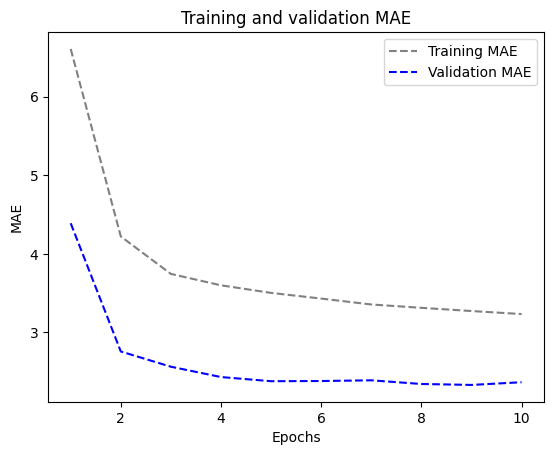

In [ ]:
import matplotlib.pyplot as plt
loss_r = history.history["mae"]
validation_loss_r = history.history["val_mae"]

epochs = range(1, len(loss_r) + 1)
plt.figure()
plt.plot(epochs, loss_r, color="grey", linestyle="dashed", label="Training MAE")
plt.plot(epochs,  validation_loss_r, color="blue",linestyle="dashed", label="Validation MAE")
plt.title("Training and validation MAE")
plt.xlabel("Epochs")
plt.ylabel("MAE")
plt.legend()
plt.show()

Bidirectional LSTM

In [ ]:
inputs_BidLSTM = keras.Input(shape=(sequencelength, rawdata1.shape[-1]))
x = layers.Bidirectional(layers.LSTM(16))(inputs)
outputs_BidLSTM = layers.Dense(1)(x)
model = keras.Model(inputs_BidLSTM,outputs_BidLSTM )

callbacks = [
    keras.callbacks.ModelCheckpoint("jena_bidirec_LSTM.keras",
                                    save_best_only=True)
]

model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history.bi = model.fit(training_data,
                    epochs=5,
                    validation_data=validation_data,
                     callbacks=callbacks)

Epoch 1/5
819/819 [==============================] - 61s 71ms/step - loss: 26.7302 - mae: 3.6974 - val_loss: 10.6651 - val_mae: 2.5137
Epoch 2/5
819/819 [==============================] - 57s 69ms/step - loss: 9.4427 - mae: 2.3928 - val_loss: 9.5172 - val_mae: 2.3821
Epoch 3/5
819/819 [==============================] - 57s 70ms/step - loss: 8.4923 - mae: 2.2606 - val_loss: 10.0798 - val_mae: 2.4544
Epoch 4/5
819/819 [==============================] - 58s 70ms/step - loss: 8.0057 - mae: 2.1919 - val_loss: 10.0984 - val_mae: 2.4702
Epoch 5/5
819/819 [==============================] - 57s 70ms/step - loss: 7.6831 - mae: 2.1480 - val_loss: 10.0597 - val_mae: 2.4574


In [ ]:
model_bi = keras.models.load_model("jena_bidirec_LSTM.keras")
print(f"Test MAE: {model_bi.evaluate(testing_data)[1]:.2f}")

405/405 [==============================] - 12s 27ms/step - loss: 10.8290 - mae: 2.5671
Test MAE: 2.57


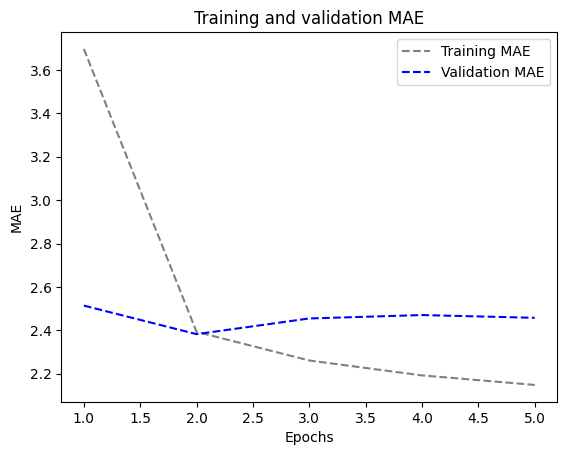

In [ ]:
import matplotlib.pyplot as plt
loss_bi = history.bi.history["mae"]
validation_loss_bi = history.bi.history["val_mae"]

epochs = range(1, len(loss_bi) + 1)
plt.figure()
plt.plot(epochs, loss_bi, color="grey", linestyle="dashed", label="Training MAE")
plt.plot(epochs,  validation_loss_bi, color="blue",linestyle="dashed", label="Validation MAE")
plt.title("Training and validation MAE")
plt.xlabel("Epochs")
plt.ylabel("MAE")
plt.legend()
plt.show()

1D Convnets and LSTM togther

In [ ]:
input_final = keras.Input(shape=(sequencelength, rawdata1.shape[-1]))
l = layers.Conv1D(64, 3, activation='relu')(input_final)
l = layers.MaxPooling1D(3)(l)
l = layers.Conv1D(128, 3, activation='relu')(l)
l = layers.GlobalMaxPooling1D()(l)
l = layers.Reshape((-1, 128))(l)  # Reshape the data to be 3D
l = layers.LSTM(16)(l)
output_final = layers.Dense(1)(l)
model_final = keras.Model(input_final, output_final)

model_final.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])

callbacks = [
    keras.callbacks.ModelCheckpoint("jena_Conv_LSTM.keras", save_best_only=True)
]

history_final = model_final.fit(training_data, epochs=5, validation_data=validation_data, callbacks=callbacks)



Epoch 1/5
819/819 [==============================] - 20s 22ms/step - loss: 44.8877 - mae: 5.0064 - val_loss: 24.4481 - val_mae: 3.8367
Epoch 2/5
819/819 [==============================] - 17s 21ms/step - loss: 17.1788 - mae: 3.2103 - val_loss: 20.8368 - val_mae: 3.6123
Epoch 3/5
819/819 [==============================] - 17s 21ms/step - loss: 14.0989 - mae: 2.9200 - val_loss: 22.7527 - val_mae: 3.7484
Epoch 4/5
819/819 [==============================] - 17s 21ms/step - loss: 12.5468 - mae: 2.7461 - val_loss: 26.6769 - val_mae: 4.1778
Epoch 5/5
819/819 [==============================] - 17s 21ms/step - loss: 11.4257 - mae: 2.6111 - val_loss: 23.7673 - val_mae: 3.8498


In [ ]:
model_final = keras.models.load_model("jena_Conv_LSTM.keras")
print(f"Test MAE: {model_final.evaluate(testing_data)[1]:.2f}")

405/405 [==============================] - 5s 11ms/step - loss: 22.8396 - mae: 3.7835
Test MAE: 3.78


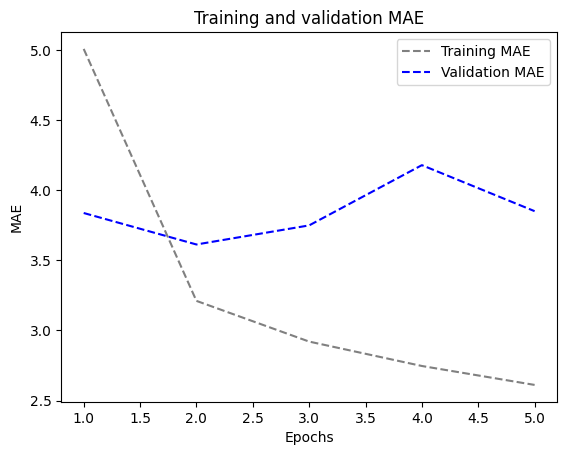

In [ ]:
import matplotlib.pyplot as plt
loss_final = history_final.history["mae"]
validation_loss_final = history_final.history["val_mae"]

epochs = range(1, len(loss_final) + 1)
plt.figure()
plt.plot(epochs, loss_final, color="grey", linestyle="dashed", label="Training MAE")
plt.plot(epochs,  validation_loss_final, color="blue",linestyle="dashed", label="Validation MAE")
plt.title("Training and validation MAE")
plt.xlabel("Epochs")
plt.ylabel("MAE")
plt.legend()
plt.show()

Built 14 models: Following are the details;

Model 1: common-sense, non-machine-learning baseline

Model 2: A basic machine-learning model

Model 3: 1D convolutional model

Model 4: Simple RNN layer that can process sequences of any length

Model 5: Simple RNN - Stacking RNN layers

Model 6: A Simple GRU (Gated Recurrent Unit)

Model 7: LSTM-Simple

Model 8: LSTM - dropout Regularization

Model 9: Stacked setup with 16 units

Model 10: Stacked setup with 32 units

Model 11: Stacked setup with 8 units

Model 12: LSTM - dropout-regularized, stacked

Model 13: Bidirectional LSTM

Model 14: 1D Convnets and LSTM togther

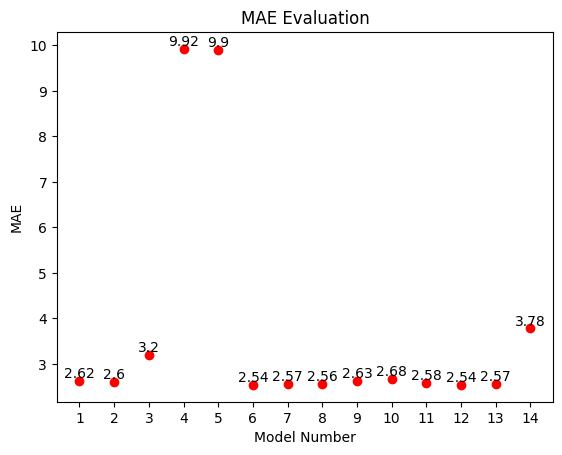

In [ ]:
Models = ("1","2","3","4","5","6","7","8","9","10","11","12","13","14")
Mae = (2.62,2.60,3.2,9.92,9.9,2.54,2.57,2.56,2.63,2.68,2.58,2.54,2.57,3.78)

# MAE Evaluation
plt.scatter(Models, Mae, color="red")
plt.title("MAE Evaluation")
plt.xlabel("Model Number")
plt.ylabel("MAE")

for (xi, yi) in zip(Models,Mae):
    plt.text(xi, yi, yi, va='bottom', ha='center')

plt.show()

